In [18]:
import os
from utils import *
from agents import *
import time
import torch
import torch.nn as nn
from copy import deepcopy
import argparse
import torch

In [19]:
parser = argparse.ArgumentParser()
parser.add_argument('--seeds',          type=int,       default=[2023, 2024, 2025])
parser.add_argument('--dataset',        type=str,       default='cifar10')
parser.add_argument('--batch_size',     type=int,       default=512)
parser.add_argument('--model_name',     type=str,       default='allcnn')
parser.add_argument('--retrain',        type=bool,      default=False)
parser.add_argument('--unlearn_class',  type=list,      default=3)
args = parser.parse_args("")
args.time_str = time.strftime("%m-%d-%H-%M", time.localtime())
if args.dataset.lower() == 'fmnist':
    args.n_channels = 1
else:
    args.n_channels = 3

if args.dataset.lower() == 'cifar100':
    args.num_classes = 100
else:
    args.num_classes = 10
criterion = nn.CrossEntropyLoss()

In [20]:
arxiv_name = 'original_model_12-20-02-15'
train_loader, val_loader, test_loader = get_dataloader(args)
remain_train_loader, unlearn_train_loader = split_2_remain_unlearn(args, train_loader)
remain_val_loader, unlearn_val_loader = split_2_remain_unlearn(args, val_loader)
remain_test_loader, unlearn_test_loader = split_2_remain_unlearn(args, test_loader)

remain_class = np.setdiff1d(np.arange(args.num_classes), args.unlearn_class)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
Acc_r, Acc_f = np.zeros((2,3)), np.zeros((2,3))

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    Acc_f[0][i], Acc_r[0][i] = test_by_class(model, test_loader, i=args.unlearn_class)

print('------------ Retrained model ------------')
for i in range(3):
    model_r = get_model(args)
    model_r.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/retrain_model_12-20-01-30_{args.seeds[i]}.pth'))
    Acc_f[1][i], Acc_r[1][i] = test_by_class(model_r, test_loader, i=args.unlearn_class)


print(f'Original model Acc_f: {100*Acc_f[0].mean():.2f} \pm {100*Acc_f[0].std():.2f}')
print(f'Original model Acc_r: {100*Acc_r[0].mean():.2f} \pm {100*Acc_r[0].std():.2f}')

print(f'Retrained model Acc_f: {100*Acc_f[1].mean():.2f} \pm {100*Acc_f[1].std():.2f}')
print(f'Retrained model Acc_r: {100*Acc_r[1].mean():.2f} \pm {100*Acc_r[1].std():.2f}')

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.7980, Acc_r: 0.9177
0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420, Acc_f: 0.8210, Acc_r: 0.9206
0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470, Acc_f: 0.7790, Acc_r: 0.9247
------------ Retrained model ------------
0.9250, 0.9590, 0.9040, 0.0000, 0.9260, 0.9290, 0.9540, 0.9150, 0.9560, 0.9440, Acc_f: 0.0000, Acc_r: 0.9347
0.8840, 0.9520, 0.9150, 0.0000, 0.9070, 0.9310, 0.9450, 0.9370, 0.9640, 0.9400, Acc_f: 0.0000, Acc_r: 0.9306
0.9390, 0.9600, 0.8580, 0.0000, 0.9330, 0.9210, 0.9630, 0.9280, 0.9540, 0.9260, Acc_f: 0.0000, Acc_r: 0.9313
Original model Acc_f: 79.93 \pm 1.72
Original model Acc_r: 92.10 \pm 0.29
Retrained model Acc_f: 0.00 \pm 0.00
Retrained model Acc_r: 93.22 \pm 0.18


## Ours

## Random labeling

In [6]:
Acc_r, Acc_f = np.zeros(3), np.zeros(3)
for i in range(1):
    print("==="*50)
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.0001)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

    for ep in range(20):
        for batch, (x, y) in enumerate(unlearn_train_loader):
            x = x.cuda()
            y = torch.from_numpy(np.random.choice(remain_class, size=x.shape[0])).cuda()
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        Acc_r[i], Acc_f[i] = test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

    model_r = get_model(args)
    model_r.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/retrain_model_12-20-01-30_{args.seeds[i]}.pth'))
    mia_lr_loss(sgd_mr_model, model_r, unlearn_val_loader, unlearn_test_loader)
    

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.7980, Acc_r: 0.9177
[train] epoch 0, batch 8, loss 5.111232280731201
0.9600, 0.9620, 0.8680, 0.2450, 0.8690, 0.7520, 0.9570, 0.9220, 0.9530, 0.9160, Acc_f: 0.2450, Acc_r: 0.9066
[train] epoch 1, batch 8, loss 4.435293674468994
0.9570, 0.9670, 0.8490, 0.1320, 0.8750, 0.6980, 0.9400, 0.9150, 0.9490, 0.9190, Acc_f: 0.1320, Acc_r: 0.8966
[train] epoch 2, batch 8, loss 3.8840243816375732
0.9460, 0.9730, 0.8480, 0.0960, 0.8840, 0.6700, 0.9290, 0.9210, 0.9450, 0.9260, Acc_f: 0.0960, Acc_r: 0.8936
[train] epoch 3, batch 8, loss 3.9424049854278564
0.9380, 0.9720, 0.8480, 0.0790, 0.8910, 0.6600, 0.9200, 0.9250, 0.9460, 0.9260, Acc_f: 0.0790, Acc_r: 0.8918
[train] epoch 4, batch 8, loss 3.7419984340667725
0.9330, 0.9740, 0.8450, 0.0680, 0.8940, 0.6510, 0.9130, 0.9310, 0.9420, 0.9220, Acc_f: 0.0680, Acc_r: 0.8894
[train] epoch 5, batch 8, loss 3.5642426013946533
0.9240, 0.9720, 0.8350, 0.0620, 0.8980, 0.6470, 

In [11]:
Acc_f = 100*np.array([0.0220, 0.0350, 0.0420])
Acc_r = 100*np.array([0.7934, 0.8369, 0.8560])
print(f'Random label Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'Random label Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

Random label Acc_f: 3.30 \pm 0.83
Random label Acc_r: 82.88 \pm 2.62


In [18]:
Proj_mat_lst =[]
train_targets_list = np.array(train_loader.dataset.targets)[train_loader.sampler.indices]
for i in range(1):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    print(f'------------ Trail {i} ------------')
    merged_feat_mat = []
    for cls_id in range(10): 
        cls_indices = np.where(np.isin(train_targets_list, cls_id))[0]
        cls_indices = train_loader.sampler.indices[cls_indices]
        cls_sampler = torch.utils.data.SubsetRandomSampler(cls_indices)
        cls_loader_dict = torch.utils.data.DataLoader(train_loader.dataset, 
                                                                batch_size=args.batch_size, 
                                                                sampler=cls_sampler)
        if cls_id in [args.unlearn_class]:
            continue
        for batch, (x, y) in enumerate(cls_loader_dict ):
            x = x.cuda()
            y = y.cuda()
            mat_list = get_representation_matrix(model, 
                                                x, 
                                                batch_list=[24, 100, 100, 125, 125, 250, 250, 256, 256])
            break
        threshold = 0.97 + 0.003*cls_id
        merged_feat_mat = update_GPM(mat_list, threshold, merged_feat_mat)
        proj_mat = [torch.Tensor(np.dot(layer_basis, layer_basis.transpose())) for layer_basis in merged_feat_mat]
        Proj_mat_lst.append(proj_mat)


------------ Trail 0 ------------
Threshold:  0.97
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 6/27
Layer 2 : 51/432
Layer 3 : 188/432
Layer 4 : 562/864
Layer 5 : 623/864
Layer 6 : 624/864
Layer 7 : 668/864
Layer 8 : 76/96
Layer 9 : 4/96
----------------------------------------
Threshold:  0.973
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 7/27
Layer 2 : 65/432
Layer 3 : 216/432
Layer 4 : 645/864
Layer 5 : 687/864
Layer 6 : 668/864
Layer 7 : 733/864
Layer 8 : 80/96
Layer 9 : 6/96
----------------------------------------
Threshold:  0.976
Skip Updating GPM for layer: 1
Skip Updating GPM for layer: 2
Skip Updating GPM for layer: 3
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 7/27
Layer 2 : 65/432
Layer 3 : 216/432
Layer 4 : 656/864
Layer 5 : 697/864
Layer 6 : 683

In [8]:
for i in range(3):
    print("==="*50)
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.04)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    for ep in range(25):
        for batch, (x, y) in enumerate(unlearn_train_loader):
            x = x.cuda()
            y = torch.from_numpy(np.random.choice(remain_class, size=x.shape[0])).cuda()
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            for k, (m,params) in enumerate(sgd_mr_model.named_parameters()):
                if len(params.size())!=1:
                    sz =  params.grad.data.size(0)
                    params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                            Proj_mat_lst[i][kk].cuda()).view(params.size())
                    kk +=1
                elif len(params.size())==1:
                    params.grad.data.fill_(0)
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
        mia_lr_loss(sgd_mr_model, model_r, unlearn_val_loader, unlearn_test_loader)

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.7980, Acc_r: 0.9177
[train] epoch 0, batch 8, loss 5.275522708892822
0.9450, 0.9510, 0.8710, 0.3430, 0.9190, 0.7900, 0.9690, 0.9160, 0.9520, 0.9320, Acc_f: 0.3430, Acc_r: 0.9161
[train] epoch 1, batch 8, loss 4.428387641906738
0.9300, 0.9360, 0.8430, 0.1300, 0.8920, 0.6250, 0.9330, 0.9070, 0.9610, 0.9380, Acc_f: 0.1300, Acc_r: 0.8850
[train] epoch 2, batch 8, loss 3.7384209632873535
0.9080, 0.9270, 0.8090, 0.0620, 0.8720, 0.5230, 0.8520, 0.8940, 0.9630, 0.9320, Acc_f: 0.0620, Acc_r: 0.8533
[train] epoch 3, batch 8, loss 3.511049509048462
0.8950, 0.9200, 0.7760, 0.0410, 0.8590, 0.4430, 0.7870, 0.8800, 0.9610, 0.9220, Acc_f: 0.0410, Acc_r: 0.8270
[train] epoch 4, batch 8, loss 3.3043365478515625
0.8780, 0.9120, 0.7640, 0.0250, 0.8260, 0.3580, 0.7120, 0.8700, 0.9600, 0.9080, Acc_f: 0.0250, Acc_r: 0.7987
[train] epoch 5, batch 8, loss 3.0357730388641357
0.8460, 0.8920, 0.7360, 0.0210, 0.7740, 0.2830, 0

In [21]:
Acc_r = 100*np.array([0.9262, 0.9239, 0.9313])
Acc_f = 100*np.array([0.0170, 0.0250, 0.0210])

print(f'Random label + Subspace Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'Random label + Subspace Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

Random label + Subspace Acc_f: 2.10 \pm 0.33
Random label + Subspace Acc_r: 92.71 \pm 0.31


In [20]:
def get_2nd_score(model, x, y):
    indices = torch.topk(model(x), k=2, dim=1).indices
    top1_matches = indices[:, 0] == y
    selected_labels = torch.where(top1_matches, indices[:, 1], indices[:, 0])
    return selected_labels

for i in range(3):
    print("==="*50)
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.04)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    model.eval()
    for ep in range(25):
        for batch, (x, y) in enumerate(unlearn_train_loader):
            x = x.cuda()
            y = get_2nd_score(model, x, y.cuda())
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            for k, (m,params) in enumerate(sgd_mr_model.named_parameters()):
                if len(params.size())!=1:
                    sz =  params.grad.data.size(0)
                    params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                            Proj_mat_lst[i][kk].cuda()).view(params.size())
                    kk +=1
                elif len(params.size())==1:
                    params.grad.data.fill_(0)
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
        mia_lr_loss(sgd_mr_model, model_r, unlearn_val_loader, unlearn_test_loader)

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.7980, Acc_r: 0.9177
[train] epoch 0, batch 8, loss 1.202215552330017
0.9440, 0.9630, 0.8860, 0.2380, 0.9030, 0.9290, 0.9640, 0.8960, 0.9460, 0.9090, Acc_f: 0.2380, Acc_r: 0.9267
Accuracy: 0.8963815789473685
[train] epoch 1, batch 8, loss 0.7880789041519165
0.9410, 0.9610, 0.8890, 0.1140, 0.9080, 0.9190, 0.9650, 0.8900, 0.9450, 0.9070, Acc_f: 0.1140, Acc_r: 0.9250
Accuracy: 0.8174342105263158
[train] epoch 2, batch 8, loss 0.6483955383300781
0.9380, 0.9610, 0.8890, 0.0730, 0.9120, 0.9160, 0.9640, 0.8920, 0.9460, 0.9080, Acc_f: 0.0730, Acc_r: 0.9251
Accuracy: 0.7960526315789473
[train] epoch 3, batch 8, loss 0.5746265053749084
0.9380, 0.9610, 0.8900, 0.0580, 0.9160, 0.9140, 0.9630, 0.8930, 0.9450, 0.9080, Acc_f: 0.0580, Acc_r: 0.9253
Accuracy: 0.7861842105263158
[train] epoch 4, batch 8, loss 0.5312460064888
0.9380, 0.9610, 0.8870, 0.0410, 0.9170, 0.9150, 0.9630, 0.8960, 0.9450, 0.9080, Acc_f: 0.0410

In [ ]:
Accuracy: 0.6447368421052632
Accuracy: 0.6282894736842105
Accuracy: 0.6101973684210527

In [ ]:
Acc_r = 100*np.array([0.9262, 0.9318, 0.9260])
Acc_f = 100*np.array([0.0050, 0.0040, 0.0070])

print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

In [ ]:
Acc_r = 100*np.array([0.9248, 0.9320, 0.9256])
Acc_f = 100*np.array([0.0120,0.0050,0.0080])

print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

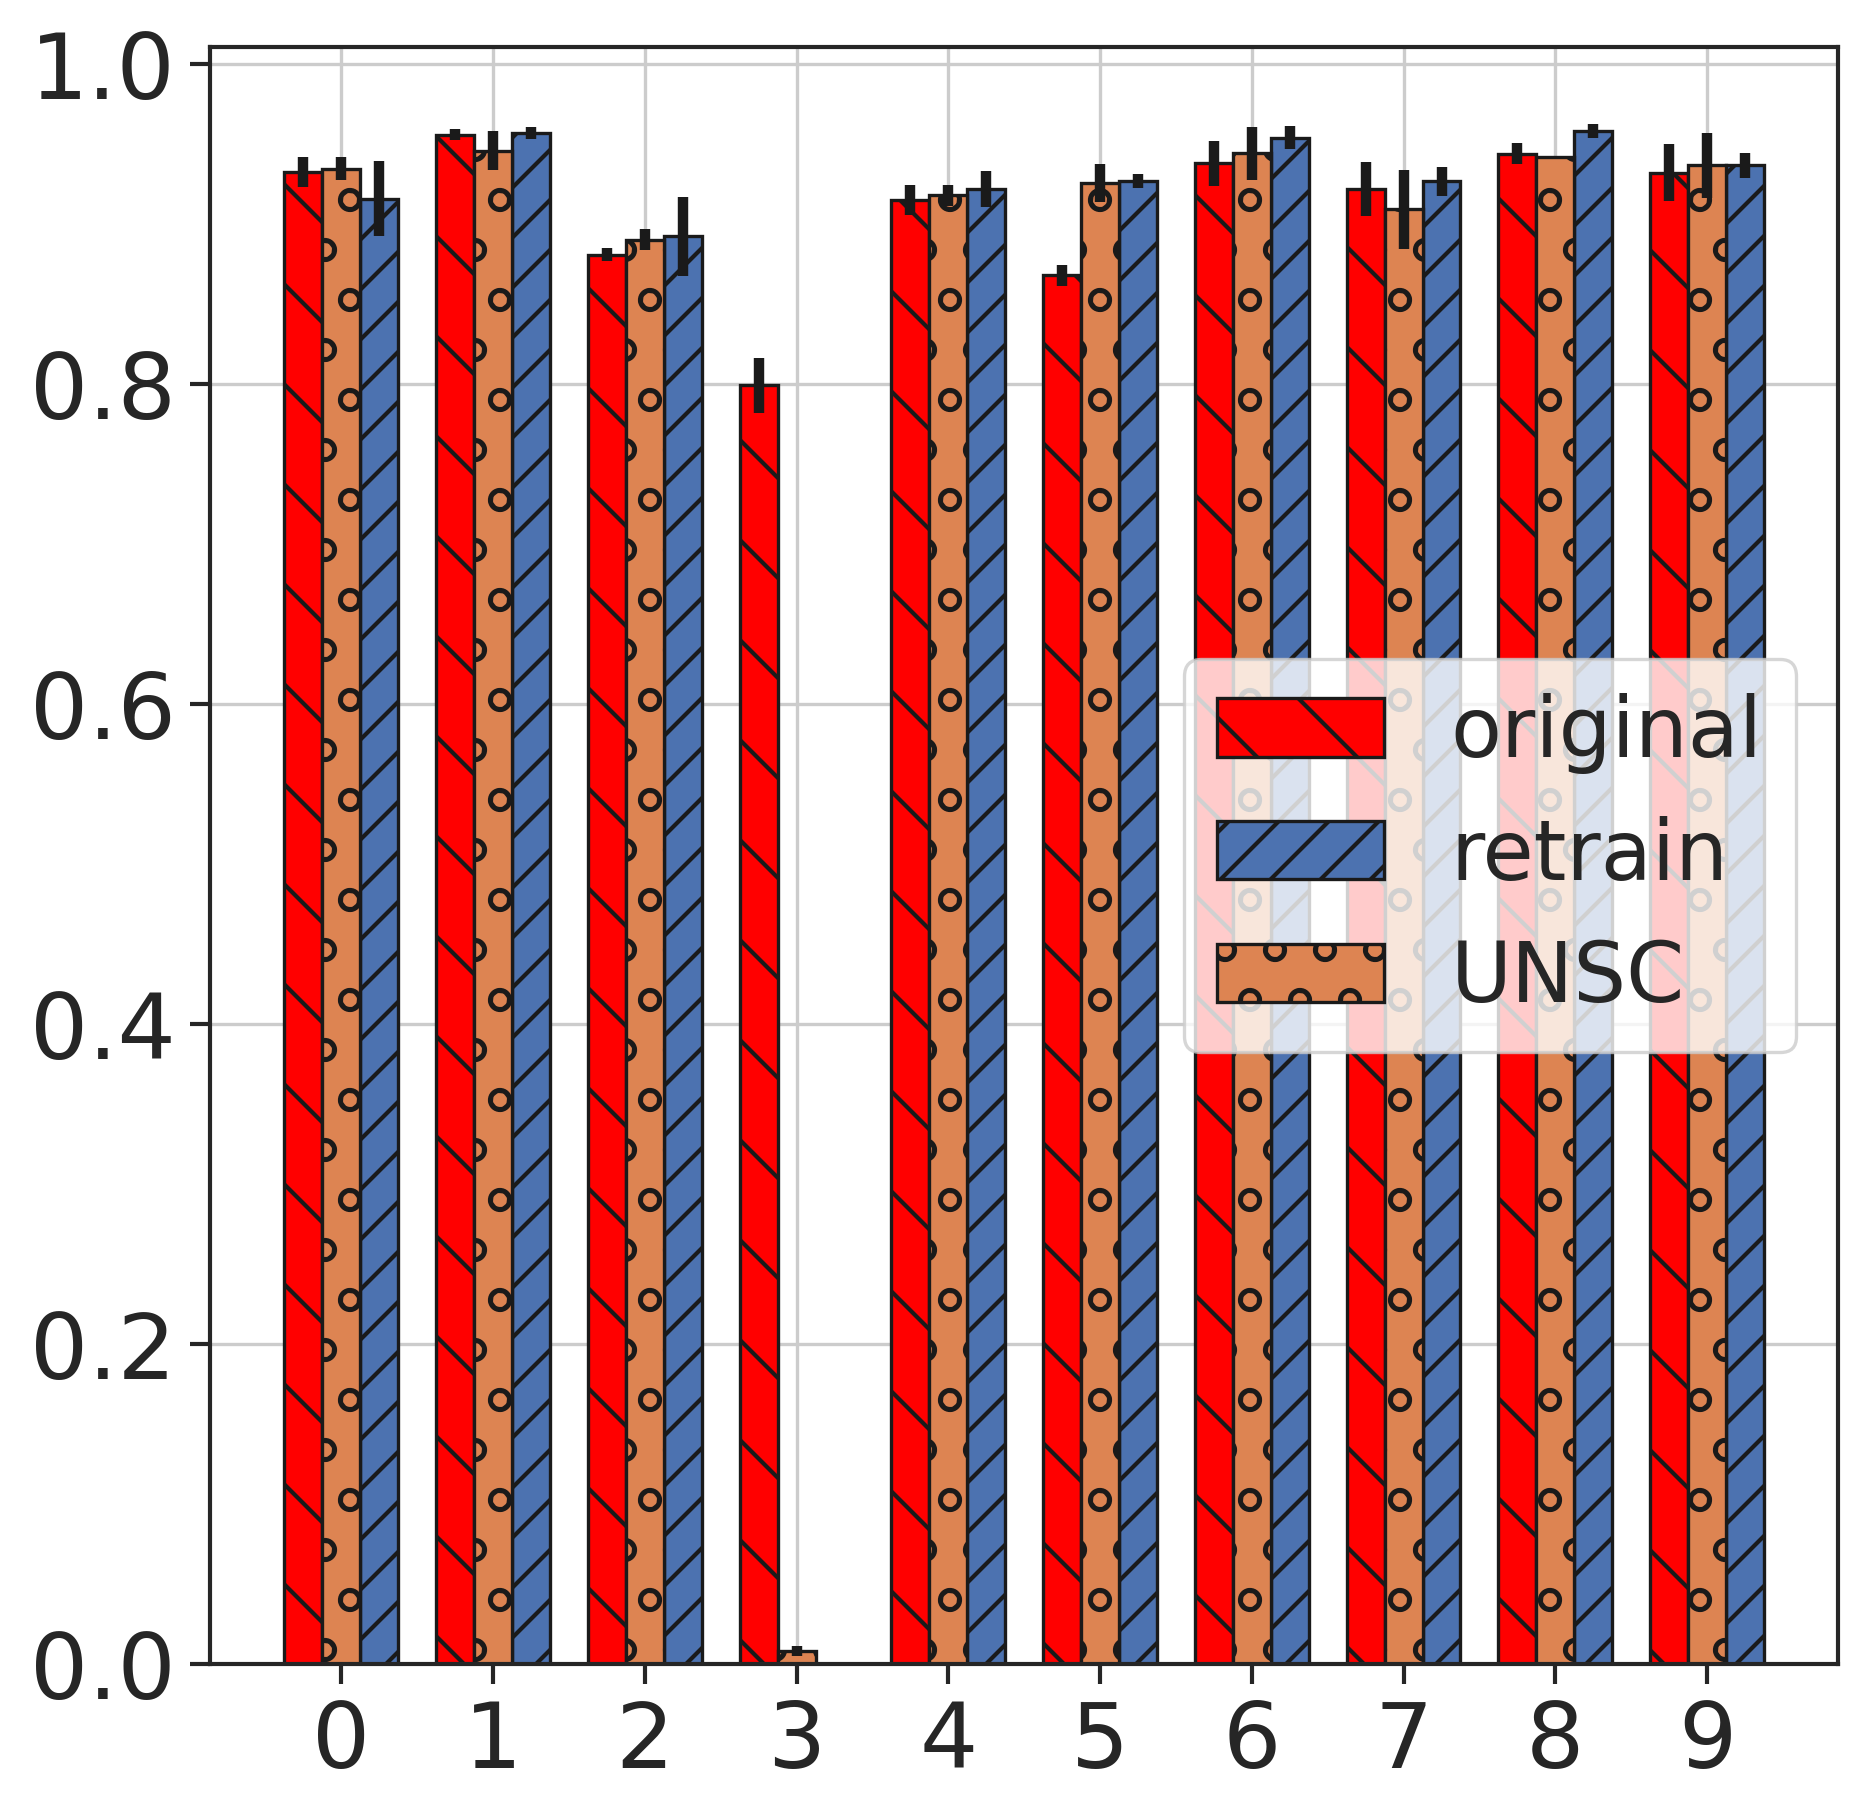

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="ticks")
sns.set_context(
    "paper",
    rc={
        "lines.linewidth": 2.5,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "lines.markersize": 15,
        "legend.fontsize": 20,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "legend.handlelength": 1,
        "legend.handleheight": 1,
    },
)

acc_o = np.array([[0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070],
                  [0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420],
                  [0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470]])

acc_r = np.array([[0.9250, 0.9590, 0.9040, 0.0000, 0.9260, 0.9290, 0.9540, 0.9150, 0.9560, 0.9440],
                  [0.8840, 0.9520, 0.9150, 0.0000, 0.9070, 0.9310, 0.9450, 0.9370, 0.9640, 0.9400],
                  [0.9390, 0.9600, 0.8580, 0.0000, 0.9330, 0.9210, 0.9630, 0.9280, 0.9540, 0.9260]])

acc_u = np.array([[0.9450, 0.9570, 0.8820, 0.0120, 0.9120, 0.9160, 0.9670, 0.8940, 0.9420, 0.9080],
                [0.9300, 0.9520, 0.8980, 0.0050, 0.9150, 0.9190, 0.9380, 0.9440, 0.9410, 0.9510],
                [0.9290, 0.9290, 0.8910, 0.0080, 0.9270, 0.9420, 0.9280, 0.8900, 0.9430, 0.9510]])

plt.figure(figsize=(7, 7), dpi=300)

mean_o = acc_o.mean(axis=0)
std_o = acc_o.std(axis=0)
mean_u = acc_u.mean(axis=0)
std_u = acc_u.std(axis=0)
mean_r = acc_r.mean(axis=0)
std_r = acc_r.std(axis=0)
x = np.arange(10)
width = 0.25

rects_o = plt.bar(x - width, mean_o, width, yerr=std_o, edgecolor='k', hatch='\\', color = 'red',label='original')
rects_r = plt.bar(x + width, mean_r, width, yerr=std_r, hatch='//', edgecolor='k', label='retrain')
rects_u = plt.bar(x, mean_u, width, yerr=std_u, hatch='o', edgecolor='k',label=r'UNSC')

plt.gca().set_xticks(x)
plt.grid()

plt.legend(loc='center right')

plt.show()



In [ ]:
Acc_r = 100*np.array([0.9274, 0.9319, 0.9334])
Acc_f = 100*np.array([0.0050, 0.0190, 0.0150])
print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

# Boundary Unlearning

In [21]:
from agents.adv import FGSM

def find_adjacent_cls(adv_agent, x, y):
    x_adv = adv_agent.perturb(x, y)
    adv_logits = model(x_adv)
    adv_pred = torch.argmax(adv_logits.data, 1)
    return adv_pred, x_adv

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))  

    adv_agent = FGSM(deepcopy(model), bound=0.1, norm=False, random_start=True, device='cuda')
    sgd_mr_model = deepcopy(model)
    print('==='*60)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.001)

    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()
            
    model.eval()
    for ep in range(15):
        for batch, (x, y) in enumerate(unlearn_train_loader):
            x = x.cuda()
            adv_pred, x_adv = find_adjacent_cls(adv_agent, x, y)
            adv_y = torch.argmax(model(x_adv), dim=1).detach().cuda()
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, adv_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
        mia_lr_loss(sgd_mr_model, model_r, unlearn_val_loader, unlearn_test_loader)
        

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.7980, Acc_r: 0.9177
[train] epoch 0, batch 8, loss 2.18019700050354
0.9790, 0.9260, 0.8250, 0.0280, 0.9200, 0.7050, 0.9240, 0.8000, 0.9340, 0.8680, Acc_f: 0.0280, Acc_r: 0.8757
Accuracy: 0.84375
[train] epoch 1, batch 8, loss 1.8966368436813354
0.9790, 0.9070, 0.7860, 0.0250, 0.9090, 0.6850, 0.9150, 0.7590, 0.9280, 0.8400, Acc_f: 0.0250, Acc_r: 0.8564
Accuracy: 0.8963815789473685
[train] epoch 2, batch 8, loss 1.8328064680099487
0.9700, 0.8910, 0.7790, 0.0200, 0.9200, 0.6820, 0.8980, 0.7280, 0.9300, 0.8250, Acc_f: 0.0200, Acc_r: 0.8470
Accuracy: 0.930921052631579
[train] epoch 3, batch 8, loss 1.757365107536316
0.9630, 0.8860, 0.7820, 0.0180, 0.9190, 0.7000, 0.8990, 0.7090, 0.9240, 0.8040, Acc_f: 0.0180, Acc_r: 0.8429
Accuracy: 0.930921052631579
[train] epoch 4, batch 8, loss 1.7815353870391846
0.9510, 0.8780, 0.7750, 0.0130, 0.9320, 0.6980, 0.9130, 0.6610, 0.9390, 0.7950, Acc_f: 0.0130, Acc_r: 0.8

In [ ]:
Accuracy: 0.9342105263157895
Accuracy: 0.944078947368421
Accuracy: 0.9490131578947368

In [25]:
Acc_r = 100*np.array([0.8416, 0.8747, 0.9010])
Acc_f = 100*np.array([0.0140, 0.0130, 0.0170])
print(f'Boundary Unlearning Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'Boundary Unlearning Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

Boundary Unlearning Acc_f: 1.47 \pm 0.17
Boundary Unlearning Acc_r: 87.24 \pm 2.43


# Gradient Ascent

In [ ]:
import math
for i in range(3):
    print('==='*60)
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))  

    sgd_mr_model = deepcopy(model)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.00005)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

    for ep in range(30):
        for batch, (x, y) in enumerate(unlearn_train_loader):
            x = x.cuda()
            y = y.cuda()
            pred_y = sgd_mr_model(x)
            loss = -criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        if math.isnan(loss.item()):
            break
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
        mia_lr_loss(sgd_mr_model, model_r, unlearn_val_loader, unlearn_test_loader)

In [28]:
Acc_r = 100*np.array([0.8848,  0.8719,  0.8991])
Acc_f = 100*np.array([0.0930,  0.0460,  0.0650])

print(f'GA Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'GA Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

GA Acc_f: 6.80 \pm 1.93
GA Acc_r: 88.53 \pm 1.11


## Fisher unlearning

In [96]:
import copy
import torch.nn.functional as F

def hessian(model, train_loader):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    device = torch.device("cuda")

    for p in model.parameters():
        p.grad2_acc = 0
    
    for data, orig_target in tqdm(train_loader):
        data, orig_target = data.to(device), orig_target.to(device)
        output = model(data)
        prob = F.softmax(output, dim=-1).data

        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad2_acc += torch.mean(prob[:, y]) * p.grad.data.pow(2) 

    for p in model.parameters():
        p.grad2_acc /= len(train_loader)
    
def get_mean_var(args, p, alpha=1e-7):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3) 
    if p.size(0) == args.num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var 
    
    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    mu = copy.deepcopy(p.data0.clone())

    if p.size(0) == args.num_classes:
        mu[args.unlearn_class] = 0
        var[args.unlearn_class] = 0.0001
        var *= 10
    elif p.ndim == 1:
        var *= 10 
    return mu, var

def fisher_new(model, train_loader):
    for p in model.parameters():
        p.data0 = copy.deepcopy(p.data.clone())
    hessian(model, train_loader)
    for i, p in enumerate(model.parameters()):
        mu, var = get_mean_var(args, p)
        p.data = mu + var.sqrt() * torch.empty_like(p.data).normal_()
    return model

In [30]:

remain_dataset = torch.utils.data.Subset(train_loader.dataset, remain_indices)

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))  
    test_by_class(model, test_loader, i=args.unlearn_class)
    fisher_model = copy.deepcopy(model)
    fisher_new(remain_dataset, fisher_model)
    test_by_class(fisher_model, test_loader, i=args.unlearn_class)

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.7980, Acc_r: 0.9177


100%|██████████| 80/80 [00:14<00:00,  5.42it/s]


0.9630, 0.9560, 0.8980, 0.0010, 0.8610, 0.9020, 0.9260, 0.9020, 0.9200, 0.9020, Acc_f: 0.0010, Acc_r: 0.9144
0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420, Acc_f: 0.8210, Acc_r: 0.9206


100%|██████████| 80/80 [00:14<00:00,  5.36it/s]


0.9060, 0.9570, 0.8710, 0.0010, 0.9100, 0.9510, 0.9420, 0.9380, 0.9390, 0.9480, Acc_f: 0.0010, Acc_r: 0.9291
0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470, Acc_f: 0.7790, Acc_r: 0.9247


100%|██████████| 80/80 [00:15<00:00,  5.33it/s]


0.9410, 0.9480, 0.8790, 0.0000, 0.9230, 0.8980, 0.9550, 0.9570, 0.9460, 0.9460, Acc_f: 0.0000, Acc_r: 0.9326


In [31]:
Acc_r = 100*np.array([0.9144,  0.9291, 0.9326])
Acc_f = 100*np.array([0.0010,  0.0010, 0.0000])

print(f'Fisher Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'Fisher Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

Fisher Acc_f: 0.07 \pm 0.05
Fisher Acc_r: 92.54 \pm 0.79


# SalUn

In [21]:
train_loader, val_loader, test_loader = get_dataloader(args)
remain_train_loader, unlearn_train_loader = split_2_remain_unlearn(args, train_loader)
remain_val_loader, unlearn_val_loader = split_2_remain_unlearn(args, val_loader)
remain_test_loader, unlearn_test_loader = split_2_remain_unlearn(args, test_loader)

remain_class = np.setdiff1d(np.arange(args.num_classes), args.unlearn_class)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# create saliency map
def save_gradient_ratio(unlearn_train_loader, model, criterion, args, seed):
    optimizer = torch.optim.SGD(
        model.parameters(),
        args.unlearn_lr,
        momentum=args.momentum,
        weight_decay=args.weight_decay,
    )
    gradients = {}
    model.eval()
    for name, param in model.named_parameters():
        gradients[name] = 0

    for i, (image, target) in enumerate(unlearn_train_loader):
        image = image.cuda()
        target = target.cuda()

        # compute output
        output_clean = model(image)
        loss = - criterion(output_clean, target)

        optimizer.zero_grad()
        loss.backward()

        with torch.no_grad():
            for name, param in model.named_parameters():
                if param.grad is not None:
                    gradients[name] += param.grad.data

    with torch.no_grad():
        for name in gradients:
            gradients[name] = torch.abs_(gradients[name])

    threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    for i in threshold_list:
        print(i)
        sorted_dict_positions = {}
        hard_dict = {}

        # Concatenate all tensors into a single tensor
        all_elements = - torch.cat([tensor.flatten() for tensor in gradients.values()])

        # Calculate the threshold index for the top 10% elements
        threshold_index = int(len(all_elements) * i)

        # Calculate positions of all elements
        positions = torch.argsort(all_elements)
        ranks = torch.argsort(positions)

        start_index = 0
        for key, tensor in gradients.items():
            num_elements = tensor.numel()
            # tensor_positions = positions[start_index: start_index + num_elements]
            tensor_ranks = ranks[start_index : start_index + num_elements]

            sorted_positions = tensor_ranks.reshape(tensor.shape)
            sorted_dict_positions[key] = sorted_positions

            # Set the corresponding elements to 1
            threshold_tensor = torch.zeros_like(tensor_ranks)
            threshold_tensor[tensor_ranks < threshold_index] = 1
            threshold_tensor = threshold_tensor.reshape(tensor.shape)
            hard_dict[key] = threshold_tensor
            start_index += num_elements

        torch.save(hard_dict, f'./save/{args.dataset}/{args.model_name}/mask_threshold_{seed}_{i}.pt')


args.unlearn_lr=0.01
args.momentum=0.9
args.weight_decay=5e-4
criterion = nn.CrossEntropyLoss()

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    save_gradient_ratio(unlearn_train_loader, model, criterion, args, args.seeds[i])

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [24]:
from agents.svc_mia import SVC_MIA
indice = remain_train_loader.sampler.indices
neg_size = len(test_loader.sampler) + len(val_loader.sampler.indices)
balanced_indice = np.random.choice(indice, size=neg_size, replace=False)
balanced_sampler = torch.utils.data.SubsetRandomSampler(balanced_indice)
balanced_train_loader = torch.utils.data.DataLoader(remain_train_loader.dataset,
                                                    batch_size=args.batch_size,
                                                    sampler=balanced_sampler)

threshold = 0.8
MIA_acc = np.zeros(3)
for i in range(3):
    print("======="*50)
    mask = torch.load(f'./save/{args.dataset}/{args.model_name}/mask_threshold_{args.seeds[i]}_{threshold}.pt')
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.0001)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    for ep in range(8):
        for batch, (x, y) in enumerate(unlearn_train_loader):
            x = x.cuda()
            y = torch.from_numpy(np.random.choice(remain_class, size=x.shape[0])).cuda()
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            for name, param in sgd_mr_model.named_parameters():
                if param.grad is not None:
                    param.grad *= mask[name]
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

    MIA_acc[i] =  SVC_MIA(shadow_train=balanced_train_loader, 
            target_train=None, 
            target_test=unlearn_train_loader,
            shadow_test=test_loader, 
            model=sgd_mr_model)
print(f'MIA acc: {MIA_acc.mean():.2f} \pm {MIA_acc.std():.2f}')

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.7980, Acc_r: 0.9177
[train] epoch 0, batch 8, loss 5.063453197479248
0.9580, 0.9620, 0.8760, 0.2510, 0.8810, 0.7760, 0.9600, 0.9190, 0.9540, 0.9160, Acc_f: 0.2510, Acc_r: 0.9113
[train] epoch 1, batch 8, loss 4.492182731628418
0.9560, 0.9660, 0.8580, 0.1310, 0.8770, 0.7230, 0.9460, 0.9120, 0.9560, 0.9190, Acc_f: 0.1310, Acc_r: 0.9014
[train] epoch 2, batch 8, loss 4.212754726409912
0.9510, 0.9700, 0.8470, 0.0940, 0.8830, 0.6920, 0.9340, 0.9180, 0.9470, 0.9250, Acc_f: 0.0940, Acc_r: 0.8963
[train] epoch 3, batch 8, loss 3.9909756183624268
0.9440, 0.9720, 0.8430, 0.0760, 0.8890, 0.6720, 0.9260, 0.9230, 0.9480, 0.9290, Acc_f: 0.0760, Acc_r: 0.8940
[train] epoch 4, batch 8, loss 3.8155105113983154
0.9360, 0.9720, 0.8400, 0.0650, 0.8910, 0.6640, 0.9170, 0.9240, 0.9480, 0.9290, Acc_f: 0.0650, Acc_r: 0.8912
[train] epoch 5, batch 8, loss 3.786559820175171
0.9300, 0.9710, 0.8360, 0.0600, 0.8980, 0.6540, 0.

In [25]:
Acc_r = 100*np.array([0.8862,  0.8894,  0.8908])
Acc_f = 100*np.array([0.0500,  0.0680,  0.0670])

print(f'SalUn Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'SalUn Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

SalUn Acc_f: 6.17 \pm 0.83
SalUn Acc_r: 88.88 \pm 0.19
